In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import copy
import random
from matplotlib import pyplot as plt
import numpy as np
#From keras
import keras
from keras.models import load_model
# from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from keras import optimizers
from keras.utils import multi_gpu_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
# From ssd_keras
from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
import ssd_encoder_decoder.ssd_output_decoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections
from SSD_loss import SSDLoss
from eval_utils.average_precision_evaluator import Evaluator
from importlib import reload
#import cv2
from data_augment import LabelEncoder
from detector_help import process_y,post_process,prior_box
import detection_nets,classification_nets
import tensorflow as tf
from matplotlib import pyplot as plt
from drawing import *
from detection_nets import load_mobilenetv2
%matplotlib inline

### Set model config

In [6]:
input_H = 300
input_W = 300
input_C = 3
input_shape = (input_H, input_W, input_C)
model_name = "rfblite_mn2_300_b"
root_path = "/home/cai/dataset/VOCdevkit"
aspect_ratios = [[2,3],
                 [2,3],
                 [2,3],
                 [2,3],
                 [2],
                 [2]]
prior_config =  [2 + len(ar) * 2 for ar in aspect_ratios]  # number of boxes per feature map location
source_layers = ["block_12_expand"] #["block_6_expand","block_12_expand"]
#Extra layer head:  
#rfblite    oup, expand, stride, dep_mul, as_source
#plain      oup, None, stride, pad, as_source
extra_config = [
               [170, 0.25,  1,    4,  True],
               [512, None, 2, 'same', True],
               [256, None, 2, 'same', True],
               [256, None, 1, 'same', True],
               [128, None, 1, 'valid', True]]
mean_color = [123, 117, 104] 
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
num_classes = 20 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
variances = [0.1, 0.1, 0.2, 0.2]
scale = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05]

In [7]:
reload(detection_nets)
##Load basenet first
K.clear_session()
base_model = load_mobilenetv2(size = 300)
build_model = detection_nets.build_RFBNet
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3,alpha=1.0)

model = build_model(input_shape = (300,300,3),
              phase = 'train',
              source_layers = source_layers,
              base_model = base_model,
              extra_config = extra_config,
              include_base = False,
              base_index = -4,
              prior_config = prior_config,
              num_classes = num_classes,
              mean_color = mean_color,
              lite = True,
              swap_channels = swap_channels,
              return_predictor = True)

model.summary()                       #Comment this line if you don`t want to show summary every time you build your model
# print(get_flops())
model = detection_nets.preprocess(input_shape,model,mean_color,swap_channels)
# model = multi_gpu_model(model,gpus=gpus) #Comment it if don`t use multi_gpu 

#Don`t tune learning rate here because we will use a lr scheduler in callbacks
#Orignal paper used SGD but according to the author of ssd_keras, use adam is better 
model.compile(adam,
              loss=ssd_loss.loss,
              metrics = [ssd_loss.class_loss,ssd_loss.loc_loss]
              )
print(model_name,'has been built ')

[[19 19]
 [10 10]
 [ 5  5]
 [ 3  3]
 [ 3  3]
 [ 1  1]]
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 301, 301, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 150, 150, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 150, 150, 32) 128         Conv1[0][0]                      
_____________________________________

rfblite_mn2_300_b has been built 


[['block_16_depthwise' '8640']
 ['block_16_project' '307200']
 ['rfb_extras_0_expand_conv' '25600']
 ['rfb_extras_0_conv1_1_conv' '57280']
 ['rfb_extras_0_conv2_2_conv' '57280']
 ['rfb_extras_0_conv3_3_conv' '57280']
 ['rfb_source_0_expand_conv' '82944']
 ['extra_1_conv' '88570']
 ['extra_2_conv' '135680']
 ['extra_3_conv' '67840']
 ['rfb_source_0_conv1_1_conv' '103104']
 ['rfb_source_0_conv2_2_conv' '103104']
 ['rfb_source_0_conv3_3_conv' '103104']
 ['extra_4_conv' '35072']
 ['conf_0_conv' '22950']
 ['conf_1_conv' '22950']
 ['conf_2_conv' '69120']
 ['conf_3_conv' '34560']
 ['conf_4_conv' '23808']
 ['conf_5_conv' '11904']
 ['loc_0_conv' '5610']
 ['loc_1_conv' '5610']
 ['loc_2_conv' '16896']
 ['loc_3_conv' '8448']
 ['loc_4_conv' '6400']]


<BarContainer object of 25 artists>

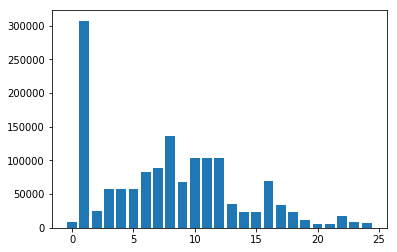

In [8]:
params = np.array([[layer.name,int(layer.count_params())]  for layer in model.layers[-1].layers[16*9+3:] if layer.count_params() > 5000])
print(params)
params = {'name':params[:,0],'params':params[:,1].astype('int')}
# plt.xticks(range(len(params)), params[:,0])
plt.bar(range(len(params["params"])),params["params"])

In [13]:
from keras.layers import *
from keras.models import *
inp = Input((7,7,3))
x = SeparableConv2D(128,3,dilation_rate = 3,depth_multiplier = 4)(inp)
print(x)

Tensor("separable_conv2d_5/BiasAdd:0", shape=(?, 1, 1, 128), dtype=float32)


### Load previously trained models 

In [ ]:
K.clear_session() # Clear previous models from memory.

model_path = "saved_weights/rfblite_mn2_300_b_pascal_07+12_epoch-44_loss-3.7695_val_loss-3.8597.h5"
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3,alpha=1.0)

# model.load_weights(model_path)
# model = multi_gpu_model(model,gpus=2) #Comment it if don`t use multi_gpu 
model = load_model(model_path,custom_objects={'loss': ssd_loss.loss,'class_loss':ssd_loss.class_loss,'loc_loss':ssd_loss.loc_loss})
print("load model from",model_path)   

In [14]:
feature_map_300 = [19,10,5,3,3,1]
feature_map_224 = [7,7,4,4,2,1]
priors = prior_box(feature_map_300,aspect_ratios,scale = scale)

### Speed Test(optional)

In [ ]:
import time
batch_n = 100
img_height = 300
img_width = 300
img_channels = 3
# detector = Detect(num_classes,0,cfg)
batch_size_range = [1,2,4,8]#[1,2,4,8]
print('Start testing...')
for batch_size in batch_size_range:
    time_total = 0
    time_net = 0
    time_post = 0
    print('batch size',batch_size)
    for i in range(0,batch_n):
        test_batch = np.random.rand(batch_size,img_height,img_width,img_channels)
        click = time.time()
        y_pred = model.predict(test_batch)
        time_net += (time.time() - click)
        click = time.time()
        y_pred_decoded = decode_detections(y_pred,
                          priors,variances,
                          img_height = input_H,
                          img_width = input_W,
                          confidence_thresh = 0.5,
                          iou_threshold = 0.45)
        time_post += (time.time() - click)
    time_total = time_net + time_post
    print('Time cost per batch: %.3f FPS: %.1f'%(time_total / batch_n,batch_n*batch_size/ time_total))
    print('Time(pure forward) cost per batch: %.3f FPS: %.1F'%(time_net / batch_n, batch_n*batch_size/ time_net))
batch_size = None
          

### Data config

In [15]:

#Define class_names
class_names = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

force_create_dataset = False #Force data generator to load dataset from source
root_path = '/home/cai/dataset/VOCdevkit'
trainset_hdf5_path = 'dataset_pascal_voc_07+12_trainval.h5'
valset_hdf5_path = 'dataset_pascal_voc_07_test.h5'

# The directories that contain the images.
VOC_2007_images_dir      = root_path + '/VOC2007/JPEGImages/'
VOC_2012_images_dir      = root_path + '/VOC2012/JPEGImages/'

# The directories that contain the annotations.
VOC_2007_annotations_dir      = root_path + '/VOC2007/Annotations/'
VOC_2012_annotations_dir      = root_path + '/VOC2012/Annotations/'

# The paths to the image sets.
VOC_2007_train_image_set_filename    = root_path + '/VOC2007/ImageSets/Main/train.txt'
VOC_2012_train_image_set_filename    = root_path + '/VOC2012/ImageSets/Main/train.txt'
VOC_2007_val_image_set_filename      = root_path + '/VOC2007/ImageSets/Main/val.txt'
VOC_2012_val_image_set_filename      = root_path + '/VOC2012/ImageSets/Main/val.txt'
VOC_2007_trainval_image_set_filename = root_path + '/VOC2007/ImageSets/Main/trainval.txt'
VOC_2012_trainval_image_set_filename = root_path + '/VOC2012/ImageSets/Main/trainval.txt'
VOC_2007_test_image_set_filename     = root_path + '/VOC2007/ImageSets/Main/test.txt'

## Load Dataset

In [37]:
if os.path.isfile(trainset_hdf5_path) and os.path.isfile(valset_hdf5_path) and not force_create_dataset:
    #Load dataset from created hdf5_dataset
    train_dataset = DataGenerator(hdf5_dataset_path = trainset_hdf5_path)
    val_dataset = DataGenerator(hdf5_dataset_path = valset_hdf5_path)
else:
    train_dataset = DataGenerator()
    val_dataset = DataGenerator()
    
    train_dataset.parse_xml(images_dirs=[VOC_2007_images_dir,
                                         VOC_2012_images_dir],
                            image_set_filenames=[VOC_2007_trainval_image_set_filename,
                                                 VOC_2012_trainval_image_set_filename],
                            annotations_dirs=[VOC_2007_annotations_dir,
                                              VOC_2012_annotations_dir],
                            classes=class_names,
                            include_classes='all',
                            exclude_truncated=False,
                            exclude_difficult=False,
                            ret=False)

    val_dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                          image_set_filenames=[VOC_2007_test_image_set_filename],
                          annotations_dirs=[VOC_2007_annotations_dir],
                          classes=class_names,
                          include_classes='all',
                          exclude_truncated=False,
                          exclude_difficult=True,
                          ret=False)
    train_dataset.create_hdf5_dataset(file_path=trainset_hdf5_path,
                                      resize=False,
                                      variable_image_size=True,
                                      verbose=True)

    val_dataset.create_hdf5_dataset(file_path=valset_hdf5_path,
                                    resize=False,
                                    variable_image_size=True,
                                    verbose=True)

Loading evaluation-neutrality annotations: 100%|██████████| 4952/4952 [00:00<00:00, 6482.94it/s]


## Data Augment 

In [17]:
import detector_help
reload(detector_help)
from detector_help import *
import data_augment
reload(data_augment)
from data_augment import *

batch_size = 32
ssd_data_augmentation = SSDDataAugmentation(img_height=input_H,
                                            img_width=input_W,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=input_H, width=input_W)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
label_encoder = LabelEncoder(num_classes,priors,variances,input_H,input_W)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=label_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=label_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()
print("Number of priors:\t{:>6}".format(len(priors)))
print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of priors:	  3010
Number of images in the training dataset:	 16551
Number of images in the validation dataset:	  4952


## Draw a batch of images(optional)

In [ ]:
train_flow_origin = train_dataset.generate(batch_size = 4,
                                           transformations=[], 
                                           label_encoder = label_encoder,
                                           returns = ['original_images','original_labels'])
images,labels = next(train_flow_origin)
for img,label in zip(images, labels):
    draw_detection(img,label,class_names)           

### Set training params

In [32]:
#If load weights from files,initial_epoch need to be set to the next epoch to be trained.
initial_epoch = 102
final_epochs = 150
steps_per_epoch = 1000
plot = True

## Define callback function

In [33]:
#1. Set file path
weights_folder = 'saved_weights/'

if not os.path.isdir(weights_folder):
    os.mkdir(weights_folder)

checkpoint_filepath = weights_folder + model_name + '_pascal_07+12_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5'
log_filepath = model_name + '_pascal_07+12_training_log.csv' 
#2. Define a lr_scheduler

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=8,
                                         verbose=1,
                                         epsilon=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)    
#3. ## Define callbacks
model_checkpoint = ModelCheckpoint(filepath = checkpoint_filepath,
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=5)

csv_logger = CSVLogger(filename=log_filepath,
                           separator=',',
                           append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)
terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             reduce_learning_rate,
             terminate_on_nan]
# callbacks = [csv_logger,learning_rate_scheduler]

## Train the model

In [34]:
print('model name' ,model_name , \
       '\nstart fitting.. ' , 
       'inital epoch:', initial_epoch,
       'final epoch:', final_epochs,
       'epoch step:', steps_per_epoch,
       'plot_history:' ,plot, \
       '\ntrainset size:',  train_dataset.get_dataset_size(), ' batch_size', batch_size )     

validation_steps =  val_dataset.get_dataset_size() // batch_size
history = model.fit_generator(train_generator,
                              use_multiprocessing = False, 
                              steps_per_epoch = steps_per_epoch, 
                              validation_data = val_generator,
                              validation_steps = validation_steps, 
                              epochs = final_epochs,
                              callbacks = callbacks,
                              initial_epoch = initial_epoch)

if plot:
    plot_history(history)
    plt.savefig('./%s_pascal07+12.jpg'%model_name)



model name rfblite_mn2_300_b 
start fitting..  inital epoch: 102 final epoch: 150 epoch step: 1000 plot_history: True 
trainset size: 16551  batch_size 32
Epoch 103/150

Epoch 00103: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 969s 969ms/step - loss: 2.2204 - class_loss: 1.5649 - loc_loss: 0.6458 - val_loss: 2.6882 - val_class_loss: 1.8813 - val_loc_loss: 0.7972
Epoch 104/150

Epoch 00104: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 951s 951ms/step - loss: 2.2166 - class_loss: 1.5586 - loc_loss: 0.6483 - val_loss: 2.6990 - val_class_loss: 1.8932 - val_loc_loss: 0.7961
Epoch 105/150

Epoch 00105: LearningRateScheduler setting learning rate to 0.0001.
1000/1000 [==============================] - 958s 958ms/step - loss: 2.2402 - class_loss: 1.5699 - loc_loss: 0.6607 - val_loss: 2.7439 - val_class_loss: 1.9310 - val_loc_loss: 0.8033
Epoch 106/150

Epoch 00106: LearningRateSchedul

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 953s 953ms/step - loss: 2.1294 - class_loss: 1.5009 - loc_loss: 0.6198 - val_loss: 2.6867 - val_class_loss: 1.8853 - val_loc_loss: 0.7927
Epoch 131/150

Epoch 00131: LearningRateScheduler setting learning rate to 5e-05.
1000/1000 [==============================] - 956s 956ms/step - loss: 2.1330 - class_loss: 1.5008 - loc_loss: 0.6235 - val_loss: 2.6870 - val_class_loss: 1.8844 - val_loc_loss: 0.7940
Epoch 132/150

Epoch 00132: LearningRateScheduler setting learning rate to 5e-05.
1000/1000 [==============================] - 949s 949ms/step - loss: 2.1135 - class_loss: 1.4878 - loc_loss: 0.6170 - val_loss: 2.6961 - val_class_loss: 1.8948 - val_loc_loss: 0.7926

Epoch 00132: val_loss did not improve from 2.68923
Epoch 133/150

Epoch 00133: LearningRateScheduler setting learning rate to 5e-05.
 938/1000 [===========================>..] - ETA: 57s - loss: 2.1342 - class_loss: 1.5028 - loc_loss: 0.6228

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 950s 950ms/step - loss: 2.1185 - class_loss: 1.4902 - loc_loss: 0.6197 - val_loss: 2.7057 - val_class_loss: 1.9009 - val_loc_loss: 0.7962
Epoch 136/150

Epoch 00136: LearningRateScheduler setting learning rate to 5e-05.
1000/1000 [==============================] - 952s 952ms/step - loss: 2.1045 - class_loss: 1.4843 - loc_loss: 0.6117 - val_loss: 2.7005 - val_class_loss: 1.8980 - val_loc_loss: 0.7939
Epoch 137/150

Epoch 00137: LearningRateScheduler setting learning rate to 5e-05.
  92/1000 [=>............................] - ETA: 12:42 - loss: 2.0926 - class_loss: 1.4722 - loc_loss: 0.6119

KeyboardInterrupt: 

## Evaluate

### mAP 

In [38]:
import eval_utils.average_precision_evaluator
reload(eval_utils.average_precision_evaluator)
from eval_utils.average_precision_evaluator import Evaluator

In [40]:
test_dataset = DataGenerator()
test_dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                      image_set_filenames=[VOC_2007_test_image_set_filename],
                      annotations_dirs=[VOC_2007_annotations_dir],
                      classes=class_names,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=False,
                      ret=False)

print('Test size', test_dataset.get_dataset_size())

Processing image set 'test.txt': 100%|██████████| 4952/4952 [00:30<00:00, 161.40it/s]
Test size 4952


In [41]:
evaluator = Evaluator(model=model,
                      n_classes=num_classes,
                      data_generator=test_dataset,
                      model_mode='training')

results = evaluator(img_height=input_H,
                    img_width=input_W,
                    batch_size=batch_size,
                    priors = priors,
                    variances = variances,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 4952

Producing predictions batch-wise: 100%|██████████| 155/155 [02:11<00:00,  1.32it/s]
Matching predictions to ground truth, class 1/20.: 100%|██████████| 6773/6773 [00:00<00:00, 10628.50it/s]
Matching predictions to ground truth, class 2/20.: 100%|██████████| 4376/4376 [00:00<00:00, 12365.37it/s]
Matching predictions to ground truth, class 3/20.: 100%|██████████| 14486/14486 [00:01<00:00, 13423.15it/s]
Matching predictions to ground truth, class 4/20.: 100%|██████████| 14987/14987 [00:01<00:00, 12962.25it/s]
Matching predictions to ground truth, class 5/20.: 100%|██████████| 39574/39574 [00:01<00:00, 19816.73it/s]
Matching predictions to ground truth, class 6/20.: 100%|██████████| 2879/2879 [00:00<00:00, 10763.10it/s]
Matching predictions to ground truth, class 7/20.: 100%|██████████| 40793/40793 [00:03<00:00, 11859.97it/s]
Matching predictions to ground truth, class 8/20.: 100%|██████████| 2451/2451 [00:00<00:00, 10841.96it/s]
Matching p

In [42]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(class_names[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

aeroplane     AP    0.72
bicycle       AP    0.793
bird          AP    0.599
boat          AP    0.567
bottle        AP    0.276
bus           AP    0.776
car           AP    0.773
cat           AP    0.794
chair         AP    0.467
cow           AP    0.694
diningtable   AP    0.725
dog           AP    0.798
horse         AP    0.797
motorbike     AP    0.789
person        AP    0.669
pottedplant   AP    0.404
sheep         AP    0.688
sofa          AP    0.722
train         AP    0.81
tvmonitor     AP    0.688

              mAP   0.678


In [ ]:
m = max((num_classes + 1) // 2, 2)
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
for i in range(m):
    for j in range(n):
        if n*i+j+1 > num_classes: break
        cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
        cells[i, j].set_xlabel('recall', fontsize=14)
        cells[i, j].set_ylabel('precision', fontsize=14)
        cells[i, j].grid(True)
        cells[i, j].set_xticks(np.linspace(0,1,11))
        cells[i, j].set_yticks(np.linspace(0,1,11))
        cells[i, j].set_title("{}, AP: {:.3f}".format(class_names[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)

### Predict

In [73]:
# 1: Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

In [85]:

# Generate batch_items
batch_images, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # Which batch item to look at

#print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))


# 3: Make predictions.
y_pred = model.predict(batch_images)


Ground truth boxes:

[[  3  99 103 268 284]]


In [86]:
# 4: Decode labels
reload(detector_help)
y_pred_decoded = decode_detections(y_pred,
                  priors,variances,
                  img_height = input_H,
                  img_width = input_W,
                  confidence_thresh = 0.5,
                  iou_threshold = 0.45)
# y_pred_decoded = detector_help.post_process(y_pred, 
#                                             priors,
#                                             num_classes,
#                                             input_H, 
#                                             input_W,
#                                             score_thresh = 0.5,
#                                             iou_thresh = 0.4)
y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)
np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  3.     0.83  88.   108.   279.   241.  ]]


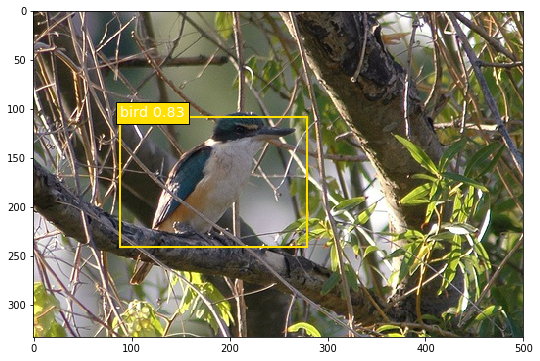

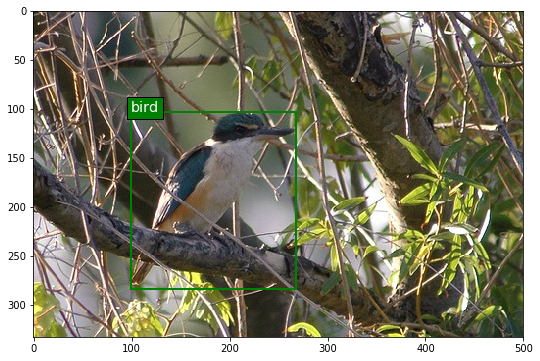

In [87]:
# 5: Draw 
colors = plt.cm.hsv(np.linspace(0, 1, num_classes+1)).tolist()
draw_detection(batch_original_images[i],y_pred_decoded_inv[i],class_names,
               show = True, draw_score = True,use_cm = True,color = colors, size = 'medium')
draw_detection(batch_original_images[i],batch_original_labels[i],class_names, size = 'medium')


### Image Demo

In [ ]:
img_file = "data/dog3.jpg"
img = cv2.imread(img_file)
img = cv2.resize(img,(224,224))
x = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = np.array(x,dtype='float')
x = x / 255
y_pred = model.predict(np.expand_dims(x,0))
y_pred = post_process(y_pred,priors,num_classes,input_H,input_W)
print(y_pred)
draw_detection(img,y_pred[0],class_names)

### Video detection demo

In [ ]:
video_file = "data/cat_video.mp4"
result_file = "res.avi"
cap= cv2.VideoCapture(video_file)
fps = cap.get(cv2.CAP_PROP_FPS)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
frames = (int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print('Input Video Size:',size,' Fps:',fps,' Frames:',frames)
writer = cv2.VideoWriter(result_file,cv2.VideoWriter_fourcc(*'MJPG'), fps, size)
success,frame = cap.read()
count = 1
while success:
    x = cv2.resize(frame,dsize=(input_H,input_W),interpolation=cv2.INTER_CUBIC)
    x = x / 255
    y_pred = model.predict(np.expand_dims(x,0))[0]
    y_pred [-4:] *= [*size,*size]
    draw_detection(frame, y_pred,class_names,font_scale = 1)
    writer.write(frame)
    cv2.waitKey(1)
    count += 1
    if count%50==0:
        print(y_pred)
        plt.imshow(frame)
        plt.show()
        print('.',end='')
    success,frame = cap.read()
print('done')